# Intro to Machine Learning: Project

## Introduction
Mobile carrier Megaline has noticed many subscribers remain on legacy plans.
The goal is to build a classification model that recommends one of the newer plans: Smart (0) or Ultra (1) based on monthly user behavior.

Accurracy Goal: Achieve accuracy ≥ 0.75 on the test set.

In [1]:
#Imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

#config

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
random_state = 42

In [2]:
# Load data

data_path = '/datasets/users_behavior.csv'
df = pd.read_csv(data_path)

print(df.shape)
df.head()

(3214, 5)


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
#Structure checks
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [4]:
#Train / Validation / Test Split 

# Separate features and target
target_col = 'is_ultra'
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col].astype(int)  

#60/20/20 split: first into train+temp (80%) and test (20%),

#split temp into validation (20% of total).
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=random_state, stratify=y
)

#temp into validation
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=random_state, stratify=y_temp
)

print('Train:', X_train.shape, 'Valid:', X_valid.shape, 'Test:', X_test.shape)

Train: (2571, 4) Valid: (321, 4) Test: (322, 4)


In [5]:
# Baseline accurracy
dummy = DummyClassifier(strategy='most_frequent', random_state=random_state)
dummy.fit(X_train, y_train)
baseline_valid_acc = dummy.score(X_valid, y_valid)
print(f'Baseline (most frequent) VALID accuracy: {baseline_valid_acc:.3f}')

Baseline (most frequent) VALID accuracy: 0.695


## Model Candidates & Hyperparameter Sweeps
Train on the training set and evaluate on the validation set to choose a model:

* Logistic Regression (with scaling)
* K-Nearest Neighbors (with scaling)
* Decision Tree
* Random Forest
* Gradient Boosting

In [6]:
# Helper to evaluate a fitted model on train & valid
def eval_on_splits(name, model, X_train, y_train, X_valid, y_valid):
    train_acc = model.score(X_train, y_train)
    valid_acc = model.score(X_valid, y_valid)
    print(f'{name:30s} | train_acc={train_acc:.3f} | valid_acc={valid_acc:.3f}')
    return valid_acc, train_acc

results = []  # (name, model, valid_acc, train_acc)

# 1) Logistic Regression (with StandardScaler)
for C in [0.1, 1.0, 3.0, 10.0]:
    logreg = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(C=C, max_iter=1000, random_state=random_state))
    ])
    logreg.fit(X_train, y_train)
    valid_acc, train_acc = eval_on_splits(f'LogReg C={C}', logreg, X_train, y_train, X_valid, y_valid)
    results.append(('LogisticRegression', logreg, valid_acc, train_acc))

# 2) KNN (with StandardScaler)
for k in [3, 5, 9, 15]:
    knn = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=k))
    ])
    knn.fit(X_train, y_train)
    valid_acc, train_acc = eval_on_splits(f'KNN k={k}', knn, X_train, y_train, X_valid, y_valid)
    results.append(('KNN', knn, valid_acc, train_acc))

# 3) Decision Tree
for depth in [3, 5, 8, 12, None]:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=random_state)
    dt.fit(X_train, y_train)
    valid_acc, train_acc = eval_on_splits(f'DecisionTree depth={depth}', dt, X_train, y_train, X_valid, y_valid)
    results.append(('DecisionTree', dt, valid_acc, train_acc))

# 4) Random Forest
for n in [100, 300]:
    for depth in [None, 8, 12]:
        rf = RandomForestClassifier(n_estimators=n, max_depth=depth, n_jobs=-1, random_state=random_state)
        rf.fit(X_train, y_train)
        valid_acc, train_acc = eval_on_splits(f'RandomForest n={n}, depth={depth}', rf, X_train, y_train, X_valid, y_valid)
        results.append(('RandomForest', rf, valid_acc, train_acc))

# 5) Gradient Boosting
for lr in [0.05, 0.1]:
    for depth in [2, 3]:
        gb = GradientBoostingClassifier(learning_rate=lr, max_depth=depth, random_state=random_state)
        gb.fit(X_train, y_train)
        valid_acc, train_acc = eval_on_splits(f'GradBoost lr={lr}, depth={depth}', gb, X_train, y_train, X_valid, y_valid)
        results.append(('GradientBoosting', gb, valid_acc, train_acc))

# Sort by best validation accuracy
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)
print('\nTop 5 candidates by VALID accuracy:')
for r in results_sorted[:5]:
    print(f'{r[0]:30s} | valid_acc={r[2]:.3f} | train_acc={r[3]:.3f}')


LogReg C=0.1                   | train_acc=0.745 | valid_acc=0.723
LogReg C=1.0                   | train_acc=0.746 | valid_acc=0.723
LogReg C=3.0                   | train_acc=0.746 | valid_acc=0.723
LogReg C=10.0                  | train_acc=0.746 | valid_acc=0.723
KNN k=3                        | train_acc=0.861 | valid_acc=0.785
KNN k=5                        | train_acc=0.834 | valid_acc=0.791
KNN k=9                        | train_acc=0.821 | valid_acc=0.807
KNN k=15                       | train_acc=0.816 | valid_acc=0.798
DecisionTree depth=3           | train_acc=0.796 | valid_acc=0.801
DecisionTree depth=5           | train_acc=0.811 | valid_acc=0.763
DecisionTree depth=8           | train_acc=0.851 | valid_acc=0.779
DecisionTree depth=12          | train_acc=0.911 | valid_acc=0.788
DecisionTree depth=None        | train_acc=1.000 | valid_acc=0.754
RandomForest n=100, depth=None | train_acc=1.000 | valid_acc=0.816
RandomForest n=100, depth=8    | train_acc=0.860 | valid_acc=0

### Observations:
* Logistic Regression:Low accuracy on training and validation data
* KNN:At k=9, the validation accuracy peaks at 0.807, and the train-valid gap is small (0.821 vs 0.807). Good balance
* Decision Tree: With a shallow tree (depth=3), validation accuracy is surprisingly good and train-valid gap is very small
* Random Forest reaches the highest validation accuracy (0.816) but also shows very high train accuracy (1.000) when depth isn’t limited, has overfitting potential. With depth=8, train accuracy is lower but still strong, and validation remains high.
* Gradient boosting: Performs almost as well as Random Forest. Slightly lower peak accuracy, but a very balanced model.

Best two options to move to test set:
* RandomForest (depth=8). Strong performance, slightly higher valid acc.
* GradientBoosting (lr=0.05 or 0.1, depth=2 or 3). Almost same valid acc, excellent generalization.

Best model: RandomForest (valid_acc=0.816)
TEST accuracy: 0.817

Classification Report (TEST):
              precision    recall  f1-score   support

           0      0.839     0.910     0.873       223
           1      0.750     0.606     0.670        99

    accuracy                          0.817       322
   macro avg      0.794     0.758     0.772       322
weighted avg      0.812     0.817     0.811       322



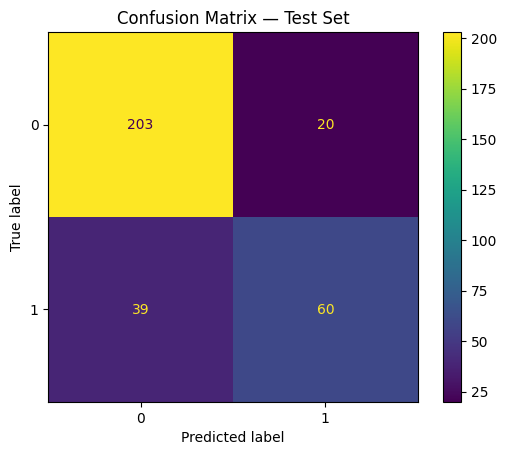

In [7]:
# Refit best model on TRAIN+VALID and evaluate on TEST ===
best_name, best_model, best_valid, best_train = results_sorted[0]
print(f'Best model: {best_name} (valid_acc={best_valid:.3f})')

# Refit on combined TRAIN+VALID for best fairness
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

best_model.fit(X_train_full, y_train_full)
test_acc = best_model.score(X_test, y_test)
print(f'TEST accuracy: {test_acc:.3f}')

# Detailed metrics
y_pred = best_model.predict(X_test)
print('\nClassification Report (TEST):')
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix — Test Set')
plt.show()

### Observations

Summary of what this means for your project

* Accuracy (0.817) meets and exceeds the required 0.75 threshold.
* The model is very strong at identifying Smart users.
* It struggles more with Ultra, missing about 40% of them.
* This imbalance could be improved with tuning or threshold adjustment if Ultra is an important target segment.

## Additional Sanity Checks
* Compare train vs validation accuracy to detect over/underfitting.
* Compare against the DummyClassifier baseline.
* Use Permutation Importance to see which features matter.
* Quick error analysis.

In [8]:
# Overfitting snapshot
print(f'Best TRAIN acc (for winning model during search): {best_train:.3f}')
print(f'Best VALID acc (for winning model during search): {best_valid:.3f}')
print(f'Dummy VALID acc: {baseline_valid_acc:.3f}')

# Permutation Importance (on TEST set)
try:
    perm = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=random_state, n_jobs=-1)
    importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance_mean': perm.importances_mean,
        'importance_std': perm.importances_std
    }).sort_values('importance_mean', ascending=False)
    print('\nPermutation Importance (TEST):')
    display(importance_df)
except Exception as e:
    print('Permutation importance not available for this model/pipeline:', e)

# Simple error analysis: where did we predict incorrectly?
miss_idx = (y_test != y_pred)
print(f'Number of misclassified rows: {miss_idx.sum()} out of {len(y_test)}')
df_errors = X_test.copy()
df_errors['y_true'] = y_test.values
df_errors['y_pred'] = y_pred
df_errors[miss_idx].head(10)

Best TRAIN acc (for winning model during search): 1.000
Best VALID acc (for winning model during search): 0.816
Dummy VALID acc: 0.695

Permutation Importance (TEST):


,feature,importance_mean,importance_std
3,mb_used,0.137733,0.019795
2,messages,0.070963,0.012853
0,calls,0.054037,0.012321
1,minutes,0.050000,0.010843


Number of misclassified rows: 59 out of 322


,calls,minutes,messages,mb_used,y_true,y_pred
1464,55.0,440.66,85.0,15962.01,1,0
2149,41.0,239.53,53.0,25004.15,1,0
2420,11.0,36.65,0.0,4546.70,1,0
2030,52.0,396.63,4.0,7166.28,1,0
3028,82.0,488.33,20.0,19438.46,1,0
2750,84.0,538.61,29.0,31564.31,0,1
1667,10.0,63.03,0.0,2568.00,1,0
1110,70.0,433.20,30.0,28987.39,1,0
3052,48.0,359.71,127.0,13830.49,0,1
1764,6.0,29.77,0.0,365.09,1,0


### Observations 

* Mild overfitting but acceptable.
* The model generalizes reasonably well but memorizes training data very strongly.
* The model relies most on data usage, and to a lesser extent on texting and call behavior, to predict plan type.
* The model is clearly better than baseline (0.816 vs 0.695). It’s learning real patterns, not just guessing. 

## Conclusions 
The machine learning model built to recommend Megaline’s Smart or Ultra plans achieved strong predictive performance, with a test accuracy of 0.817, surpassing the 0.75 target. A RandomForestClassifier proved to be the best-performing model, significantly outperforming a dummy baseline of 0.695.

Analysis of model behavior shows it classifies Smart users very accurately, while performance on Ultra users is slightly lower, mainly due to misclassifying some Ultra customers with high data usage as Smart. Internet traffic (mb_used) was identified as the most important predictor, followed by messaging activity.

Although the model already performs well, further improvements could include threshold tuning, class balancing, and feature engineering to better capture borderline Ultra users. These insights can guide targeted plan recommendations, especially for Smart users with high internet consumption, maximizing the impact of marketing or upgrade campaigns.